# Heat conduction with Neumann conditions

The immersed-layer heat equation is

$$\dfrac{\partial \overline{T}}{\partial t} = \kappa \nabla^2 \overline{T} - \kappa \nabla\cdot \delta(\chi) \mathbf{n} [T] + \delta(\chi) [q] + q''$$

where $[q] = q^+_b - q^-_b = -\kappa (\partial T^+/\partial n - \partial T^-/\partial n)$ and $[T] = T_b^+ - T_b^-$. It is important to note that, collectively,

$$\kappa \nabla^2 \overline{T} - \kappa \nabla\cdot \delta(\chi) \mathbf{n} [T] + \delta(\chi) [q]$$

represents a modified version of the Laplacian operator: the second and third term "fix" the differencing of the first term across the discontinuity, replacing the values of $\overline{T}$ across this discontinuity with the correct boundary values and boundary derivatives.

The Neumann boundary condition is

$$-\kappa \mathbf{n} \delta^{T}(\chi)\cdot \nabla \overline{T} + \kappa \mathbf{n} \delta^T(\chi)\cdot\delta(\chi) \mathbf{n} [T] = \frac{1}{2} (q_b^+ + q_b^-)$$

where $q_b^\pm$ are the heat fluxes through the immersed surface, e.g. $q_b^+ = -\kappa \partial T^+/\partial n$. The second term on the left side corrects the gradient of the masked temperature field $\overline{T}$, replacing the temperatures in this field across the discontinuity with the correct boundary values.

When we discretize spatially, we introduce $L$ for the Laplacian, $D$ and $G$ for divergence and gradient, respectively. Also, for shorthand let us denote $R$ for $\delta(\chi)$, and denote $R_n$ for the discrete version of $\delta(\chi)\mathbf{n}$, acting on surface scalars and regularizing them (multiplied by normal vectors) to a vector field on the grid. The transpose of this is $R_n^T$, the discrete version of $\mathbf{n} \delta^{T}(\chi)\cdot$.

So we can write the discrete equations for $\overline{T}$ and $[T]$ as

$$\frac{\mathrm{d} \overline{T}}{\mathrm{d} t} -\kappa L \overline{T} + \kappa DR_n [T] = q + R[q]$$
$$-\kappa R_n^T G \overline{T} + \kappa R_n^TR_n [T] = \overline{q}$$

The matrix form is

$$\begin{bmatrix}
\mathcal{L}_C^\kappa & \kappa D_s \\ -\kappa G_s & \kappa R_n^TR_n
\end{bmatrix}\begin{pmatrix}
T \\ [T]
\end{pmatrix} =
\begin{pmatrix}
q + R [q] \\ (q^+_b + q^-_b)/2
\end{pmatrix}$$

It is crucial that the time marching for solving this problem has a consistent time level
among all terms in the "modified" Laplacian. In other words, if the Laplacian term is
treated implicitly, then the other two terms must be, as well.

In [1]:
using ComputationalHeatTransfer
using Plots

## Solve the problem
We will solve heat conduction inside a square region with thermal diffusivity equal to 1.
We will apply heating through the boundary and also introduce two different
types of area heating regions in the interior.

### Set up the grid

In [2]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

### Set up the body shape.
Here, we will demonstrate the solution on a circular shape of radius 1.

In [3]:
Δs = 1.4*cellsize(g)
body = Square(1.0,Δs);

Stationary body

In [4]:
X = MotionTransform([0,0],0)
joint = Joint(X)
m = RigidBodyMotion(joint,body)
x = zero_motion_state(body,m)
update_body!(body,x,m)

Closed polygon with 4 vertices and 572 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Specify the physical parameters, data, etc.
These can be changed later without having to regenerate the system.

Here, we create a dict with physical parameters to be passed in.

In [5]:
phys_params = Dict("diffusivity" => 1.0,
                    "Fourier" => 1.0,
                    "areaheater_flux" => 10.0,
                    "areaheater_freq" => 1.0,
                     "areaheater_temp" => 1.0,
                     "areaheater_coeff" => 10.0)

Dict{String, Float64} with 6 entries:
  "areaheater_coeff" => 10.0
  "Fourier"          => 1.0
  "areaheater_temp"  => 1.0
  "diffusivity"      => 1.0
  "areaheater_freq"  => 1.0
  "areaheater_flux"  => 10.0

Define the heating region functions. We will create one heating region
with prescribed heat flux and another with a target temperature

In [6]:
fregion1 = Circle(0.2,1.4*Δx)
tr1 = MotionTransform((0.0,-0.7),0.0)

function model1!(σ,T,t,fr::AreaRegionCache,phys_params)
    σ .= phys_params["areaheater_flux"]
end
afm1 = AreaForcingModel(fregion1,tr1,model1!)

fregion2 = Circle(0.2,1.4*Δx)
tr2 = RigidTransform((-0.7,0.7),0.0)

function model2!(σ,T,t,fr::AreaRegionCache,phys_params)
    f = phys_params["areaheater_freq"]
    T0 = phys_params["areaheater_temp"]
    h = phys_params["areaheater_coeff"]
    σ .= h*(T0 - T)
end
afm2 = AreaForcingModel(fregion2,tr2,model2!);

Plot the heating regions

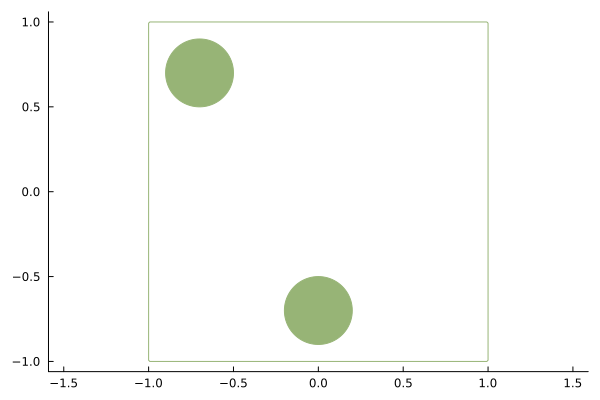

In [7]:
plot(body,fill=false)
update_body!(fregion1,tr1)
update_body!(fregion2,tr2)
plot!(fregion1)
plot!(fregion2)

Pack them together

In [8]:
forcing_dict = Dict("heating models" => AbstractForcingModel[afm1,afm2])

Dict{String, Vector{AbstractForcingModel}} with 1 entry:
  "heating models" => [AreaForcingModel{Ellipse{88}, MotionTransform{2}, Pairs{…

The heat flux boundary functions on the exterior and interior are
defined here and assembled into a dict. Note that we are using the $x$
component of the normal for the interior boundary heat flux. This sets
non-zero heat fluxes through the vertical boundaries (inward on the left,
outward on the right), and adiabatic conditions on the top and bottom.

In [9]:
function get_qbplus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbplus = zeros_surface(base_cache)
    return qbplus
end

function get_qbminus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbminus = zeros_surface(base_cache)
    qbminus .= nrm.u
    return qbminus
end

bcdict = Dict("exterior" => get_qbplus,"interior" => get_qbminus)

Dict{String, Function} with 2 entries:
  "interior" => get_qbminus
  "exterior" => get_qbplus

Construct the problem, passing in the data and functions we've just
created. We pass in the body's motion (however trivial) via the
`motions` keyword.

In [10]:
prob = NeumannHeatConductionProblem(g,body,scaling=GridScaling,
                                             phys_params=phys_params,
                                             bc=bcdict,
                                             motions=m,
                                             forcing=forcing_dict,
                                             timestep_func=timestep_fourier);

Construct the system

In [11]:
sys = construct_system(prob);

### Solving the problem
Set an initial condition. Here, we just get an initial (zeroed) copy of the
solution prototype that we have stored in the extra cache. We also
get the time step size for our own inspection.

In [12]:
u0 = init_sol(sys)

(Primal nodes in a (nx = 406, ny = 406) cell grid of type Float64 data
  Number of Primal nodes: (nx = 405, ny = 405), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

Now, create the integrator, with a time interval of 0 to 1. This uses the `HETrapezoidalAB2()`
method, by default, since it has a constraint that depends on the
Lagrange multipliers.

In [13]:
tspan = (0.0,1.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 406, ny = 406) cell grid of type Float64 data
  Number of Primal nodes: (nx = 405, ny = 405), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

Now advance the solution by 0.01 convective time units, by using the `step!` function,
which steps through the solution.

In [14]:
step!(integrator,0.01)

### Plot the solution
First, create the temperature function that allows us to easily plot.

In [15]:
temperature(T,σ,x,sys::ILMSystem,t) = T
@snapshotoutput temperature

Now plot

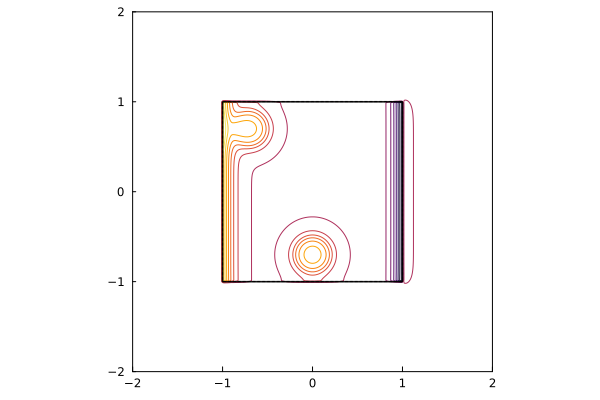

In [16]:
plot(temperature(integrator),sys)

and the Lagrange multiplier (the constraint)

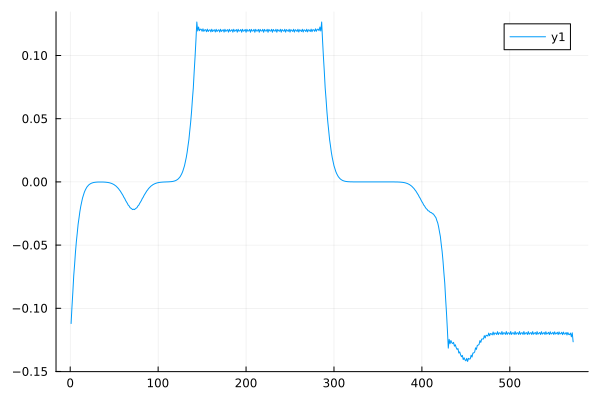

In [17]:
plot(constraint(integrator.u))

Plot a slice across the domain. To do so, we make use
of the `interpolatable_field` function, which creates a functional version
of the temperature field that we can access like a spatial field, e.g. $T(x,y)$.

In [18]:
Tfcn = interpolatable_field(temperature(integrator),sys);

First, a vertical slice along $x=0$, to verify that the adiabatic conditions
are met there.

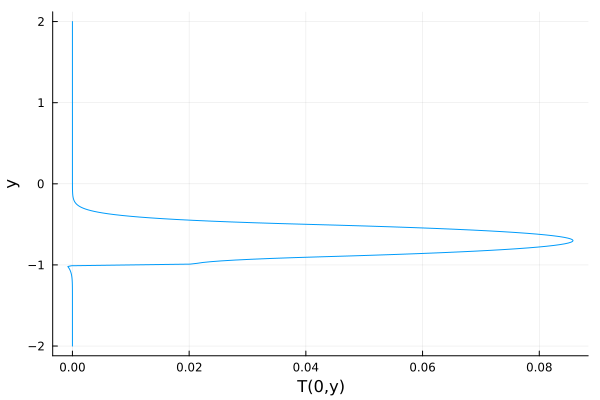

In [19]:
y = -2:0.01:2
plot(Tfcn(0,y),y,xlabel="T(0,y)",ylabel="y",legend=false)

Now, a horizontal slice along $y=0$, to verify that the adiabatic conditions
are met there.

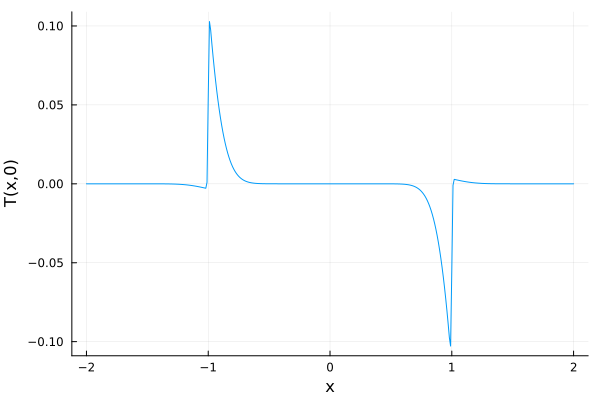

In [20]:
x = -2:0.01:2
plot(x,Tfcn(x,0),xlabel="x",ylabel="T(x,0)",legend=false)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*